In [24]:
import swat

import pandas as pd
import os
from sys import platform
import riskpy
from os.path import join as path

In [25]:
if "CASHOST" in os.environ:
    # Create a session to the CASHOST and CASPORT variables set in your environment
    conn = riskpy.SessionContext(session=swat.CAS(),
                                 caslib="CASUSER")
else:
    # Otherwise set this to your host and port:
    host = "riskpy.rqs-cloud.sashq-d.openstack.sas.com"
    port = 5570
    conn = riskpy.SessionContext(session=swat.CAS(host, port), caslib="CASUSER")

In [26]:
base_dir = '.'

# Set output location
if platform == "win32":
    # Windows...
    output_dir = 'u:\\temp'
else:
    # platform == "linux" or platform == "linux2" or platform == "darwin":
    output_dir = '/tmp'

In [27]:
mkt_data = riskpy.MarketData(
    current      = pd.DataFrame(data={'uerate': 6.0}, index=[0]),
    risk_factors = ['uerate'])

In [28]:
my_scens = riskpy.Scenarios(
    name        = "my_scens",
    market_data = mkt_data,
    data        = path("datasources","CreditRisk",'uerate_scenario.xlsx'))

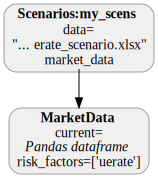

In [29]:
my_scens

In [30]:
cpty_df = pd.read_excel(path("datasources","CreditRisk",'uerate_cpty.xlsx'))
loan_groups = riskpy.Counterparties(data=pd.read_excel(
    path("datasources","CreditRisk",'uerate_cpty.xlsx')))
loan_groups.mapping = {"cpty1": "score_uerate"}

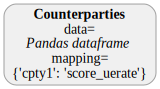

In [31]:
loan_groups

In [32]:
score_code_file=(path("methods","CreditRisk",'score_uerate.sas'))
scoring_methods = riskpy.MethodLib(
    method_code=path("methods","CreditRisk",'score_uerate.sas'))

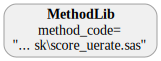

In [33]:
scoring_methods

In [34]:
my_scores = riskpy.Scores(counterparties=loan_groups,
                          scenarios=my_scens,
                          method_lib=scoring_methods)
my_scores.generate(session_context=conn, write_allscore=True)

print(my_scores.allscore.head())
allscore_file = path(output_dir, 'simple_allscores.xlsx')
my_scores.allscore.to_excel(allscore_file)

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'riskRun'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.011323 seconds
NOTE:       cpu time                0.024998 seconds (220.77%)
NOTE:       total nodes             3 (48 cores)
NOTE:       total memory            756.70G
NOTE:       memory                  705.72K (0.00%)
NOTE: Executing action 'table.addTable'.
NOTE: Action 'table.addTable' used (Total process time):
NOTE:       real time               0.034244 seconds
NOTE:       cpu time                0.063989 seconds (186.86%)
NOTE:       total nodes             3 (48 cores)
NOTE:       total memory            756.70G
NOTE:       memory                  3.31M (0.00%)
NOTE:       bytes moved             1.69K
NOTE: Added table 'Counterparties_DATA' to caslib 'CASUSER'
NOTE: Executing action 'table.loadTable'.
NOTE: Cloud Analytic Services made the uploaded file available as table MARKETDATA_CURRENT

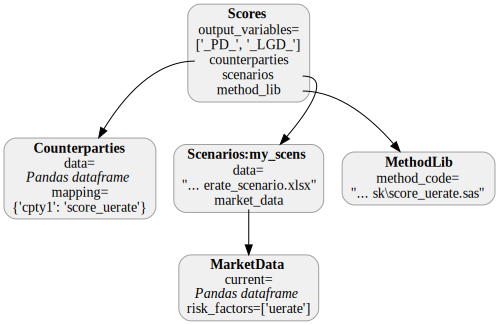

In [35]:
my_scores

In [36]:
portfolio = riskpy.Portfolio(
    data=path("datasources","CreditRisk",'retail_portfolio.xlsx'),
    class_variables = ["region", "cptyid"])

In [37]:
eval_methods = riskpy.MethodLib(
    method_code=path("methods","CreditRisk",'credit_method2.sas'))

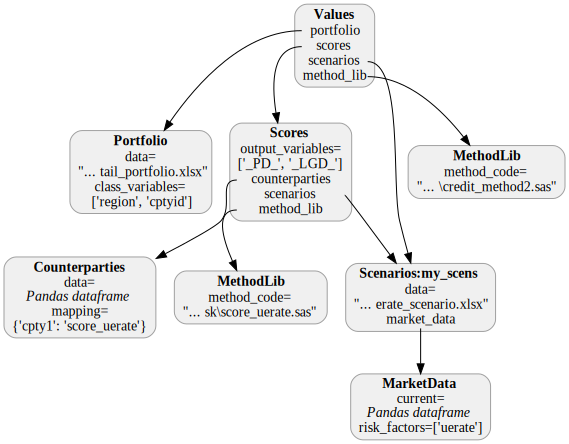

In [38]:
my_values = riskpy.Values(
                          session_context=conn,
                          portfolio=portfolio,
                          output_variables=["Expected_Credit_Loss"],
                          scenarios=my_scens,
                          scores=my_scores,
                          method_lib=eval_methods,
                          mapping = {"Retail": "ecl_method"})
my_values

In [39]:
my_values.evaluate(write_prices=True)
allprice_df = my_values.fetch_prices(max_rows=100000)
print(my_values.allprice.head())
allprice_file = path(output_dir, 'creditrisk_allprice.xlsx')
allprice_df.to_excel(allprice_file)

NOTE: Executing action 'table.loadTable'.
NOTE: Cloud Analytic Services made the uploaded file available as table PORTFOLIO in caslib CASUSER(daston).
NOTE: Action 'table.loadTable' used (Total process time):
NOTE:       real time               0.317023 seconds
NOTE:       cpu time                0.487925 seconds (153.91%)
NOTE:       data movement time      0.014851 seconds
NOTE:       total nodes             3 (48 cores)
NOTE:       total memory            756.70G
NOTE:       memory                  69.69M (0.01%)
NOTE:       bytes moved             1.03M
NOTE: The table PORTFOLIO has been created in caslib CASUSER(daston) from binary data uploaded to Cloud Analytic Services.
NOTE: Action 'table.upload' used (Total process time):
NOTE:       real time               0.366828 seconds
NOTE:       cpu time                0.531920 seconds (145.01%)
NOTE:       total nodes             3 (48 cores)
NOTE:       total memory            756.70G
NOTE:       memory                  69.69M (0.01%

In [40]:
results = riskpy.Results(
    session_context=conn,
    values=my_values,
    requests=["_TOP_", ["region"]],
    out_type="values"
)
results_df = results.query().to_frame()
print(results_df.head())
rollup_file = path(output_dir, 'creditrisk_rollup_by_region.xlsx')
results_df.to_excel(rollup_file)

NOTE: Executing action 'builtins.loadActionSet'.
NOTE: Added action set 'riskresults'.
NOTE: Action 'builtins.loadActionSet' used (Total process time):
NOTE:       real time               0.011122 seconds
NOTE:       cpu time                0.019000 seconds (170.83%)
NOTE:       total nodes             3 (48 cores)
NOTE:       total memory            756.70G
NOTE:       memory                  647.84K (0.00%)
NOTE: Executing action 'riskResults.query'.
NOTE: Starting the query action.
NOTE: The table 'Results_values' in caslib 'CASUSER(daston)' has 336 observations and 10 variables.
NOTE: Action 'riskResults.query' used (Total process time):
NOTE:       real time               1.827813 seconds
NOTE:       cpu time                4.435326 seconds (242.66%)
NOTE:       data movement time      0.008973 seconds
NOTE:       total nodes             3 (48 cores)
NOTE:       total memory            756.70G
NOTE:       memory                  178.90M (0.02%)
NOTE:       bytes moved             

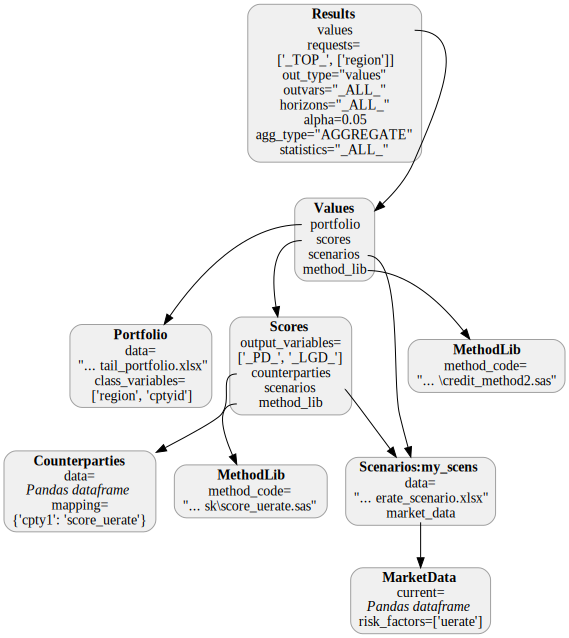

In [41]:
results 